In [4]:
import sys
sys.path.insert(0, "../")
from datetime import datetime
import rebound
import numpy as np
import matplotlib.pyplot as plt
from src.utilities.constants import rad2Deg, m2au, sec2year

In [5]:
def sim_init():
    sim = rebound.Simulation()
    sim.units = ('s', 'm', 'Kg')
    G = sim.G

    sim.add(m=1.3271244004193938e20/G)
    
    a = 329320844896.02423 # m 
    e = 0.15585014794810317
    i = 5.889091687694949/rad2Deg
    Om = 110.87633970146754/rad2Deg
    om = 285.50181319194064/rad2Deg
    M  = 15.638508490829182/rad2Deg
    sim.add(a = a, e = e, inc = i, Omega = Om, omega = om, M = M, hash = 'Flora')
    return sim

In [22]:
sim = sim_init()
sim.integrator = 'ias15'
ps = sim.particles
sim.dt = .005*ps[1].P
data = {'a':[], 'e':[], 'ax':[], 'ay':[]}
num_years = 1e3
tmax = num_years*sec2year
ts = np.linspace(0, tmax, 200)
t_start = datetime.now()
for t in ts:
    sim.integrate(t)
    data['a'].append(ps[1].a*m2au)
    data['e'].append(ps[1].e)
    data['ax'].append(ps[1].ax)
    data['ay'].append(ps[1].ay)
t_end = datetime.now()
print(t_end - t_start)

0:00:00.221971


3.9968028886505635e-15

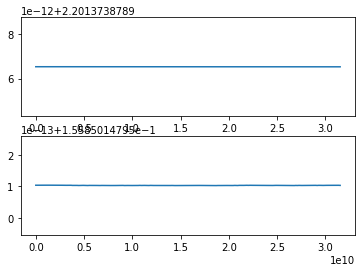

In [23]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(ts, data['a'])
ax2.plot(ts, data['e'])
au_myr = abs(data['a'][0] - data['a'][-1])/(tmax/sec2year)*num_years
au_myr

In [65]:
def radial_force(reb_sim):
    sim = reb_sim.contents
    ps = sim.particles
    a = .001/ps[1].d**2
    x, y, z = ps[1].xyz
    ps[1].ax += a*-1*y/np.linalg.norm(ps[1].xyz)
    ps[1].ay += a*x/np.linalg.norm(ps[1].xyz)

def starkForce(reb_sim):
    c = 0.01
    sim = reb_sim.contents
    ps = sim.particles
    ps[1].ax += c

def pr_drag(reb_sim):
    sim = reb_sim.contents
    ps = sim.particles
    star = ps[0]
    c = 2.998e+06
    G = sim.G
    for i, p in enumerate(ps[:]):
        if p.m >0:
            continue
        prx  = p.x-star.x
        pry  = p.y-star.y
        prz  = p.z-star.z
        pr   = np.sqrt(prx*prx + pry*pry + prz*prz)

        prvx = p.vx-star.vx
        prvy = p.vy-star.vy
        prvz = p.vz-star.vz

        rdot = (prvx*prx + prvy*pry + prvz*prz)/pr
        f = 3.321012071791588e-09
        F_r     = f*G*star.m/(pr*pr)

        sign = 1
        
        ps[i].ax += F_r*(sign * prvx/c)
        ps[i].ay += F_r*(sign * prvy/c)
        ps[i].az += F_r*(sign * prvz/c)

def yarko_da(reb_sim):
    sim = reb_sim.contents
    ps = sim.particles
    star = ps[0]
    sim.move_to_hel()
    for i, p in enumerate(ps[1:]):
        if p.m > 0:
            continue
        r = p.d
        v2 = np.dot(p.vxyz, p.vxyz)
        GM = sim.G*star.m
        energy = 1/2*v2 - GM/r
        a = -1/2*GM/energy
        dadt = .2/m2au/sec2year/1000
        K = 1/2*dadt*GM/(a*a)

        ps[i].ax += K*p.vx/v2
        ps[i].ay += K*p.vy/v2
        ps[i].az += K*p.vz/v2

In [72]:
sim = sim_init()
sim.integrator = 'ias15'
ps = sim.particles
sim.dt = .005*ps[1].P
sim.additional_forces = yarko_da
sim.force_is_velocity_dependent = True

0:00:25.562475


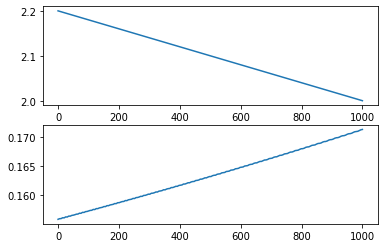

In [73]:
data_addf = {'a':[], 'e':[], 'ax':[], 'ay':[]}
t_start = datetime.now()
for t in ts:
    sim.integrate(t)
    data_addf['a'].append(ps[1].a*m2au)
    data_addf['e'].append(ps[1].e)
    data_addf['ax'].append(ps[1].ax)
    data_addf['ay'].append(ps[1].ay)
t_end = datetime.now()
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(ts/sec2year, data_addf['a'])
ax2.plot(ts/sec2year, data_addf['e'])
print(t_end - t_start)

200.00000000004593

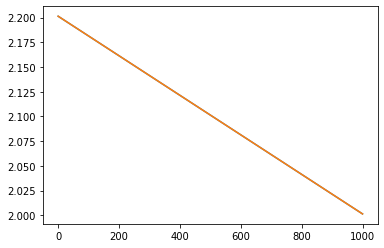

In [74]:
plt.plot(ts/sec2year, data_addf['a'])
plt.plot([0, max(ts)/sec2year], [data_addf['a'][0], min(data_addf['a'])])
au_myr = abs(data_addf['a'][0] - min(data_addf['a']))/(tmax/sec2year)*1e6
au_myr

In [59]:
e_myr = abs(data_addf['e'][0] - max(data_addf['e']))/(tmax/sec2year)*1e6
e_myr

1.3486344488389257e-05

In [74]:
33.5*1e2/60

55.833333333333336

In [3]:
# ias15 took 148s to run 10kyrs: ~4h10min for 1Myr,  ~25 weeks for 1Gyr
# mercurius took 33s to run 10kyrs: ~56min for 1Myr, ~5 weeks for 1 Gyr

In [8]:
sim.G

6.67408e-11

In [16]:
 sec2year

31536000.0

In [36]:
sa = rebound.SimulationArchive("/Users/bethclark/Projects/rebound/examples/basic_yarko/Yarko_1Myr_C.bin")

/Users/bethclark/Projects/rebound/rebound/simulationarchive.py:99: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)


In [42]:
sa[0].status()
len(sa)

---------------------------------
REBOUND version:     	3.15.0
REBOUND built on:    	Feb  4 2021 00:49:50
Number of particles: 	2
Selected integrator: 	ias15
Simulation time:     	0.0000000000000000e+00
Current timestep:    	50000.000000
---------------------------------
<rebound.particle.Particle object at 0x7fb9ef1f27c0, m=1.988475415966536e+30 x=0.0 y=0.0 z=0.0 vx=0.0 vy=0.0 vz=0.0>
<rebound.particle.Particle object at 0x7fb9ef1f2740, m=0.0 x=147947812416.90616 y=237363616215.3719 z=-22983367718.85628 vx=-19033.585490877816 vy=13368.54943043434 vz=1342.9964724414895>
---------------------------------
/Users/bethclark/Projects/rebound/rebound/simulationarchive.py:146: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/Users/bethclark/Projects/rebound/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binar

201

In [40]:
C_data = {'t':[], 'a':[], 'e':[]}
for sim in sa:
    ps = sim.particles
    C_data['t'].append(sim.t/sec2year)
    C_data['a'].append(ps[1].a*m2au)
    C_data['e'].append(ps[1].e)

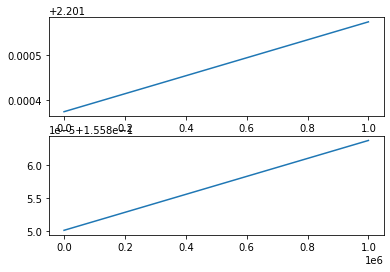

In [41]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(C_data['t'], C_data['a'])
ax2.plot(C_data['t'], C_data['e'])

0.00020002160944487812

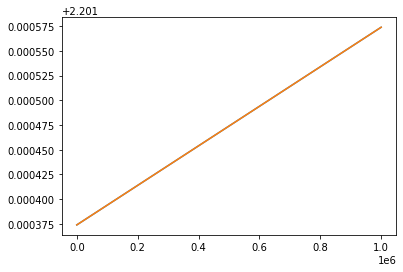

In [43]:
plt.plot(C_data['t'], C_data['a'])
plt.plot([0, max(C_data['t'])], [C_data['a'][0], max(C_data['a'])])
au_myr = abs(C_data['a'][0] - max(C_data['a']))
au_myr

In [47]:
sa[0].particles[1].P*.005

/Users/bethclark/Projects/rebound/rebound/simulationarchive.py:146: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/Users/bethclark/Projects/rebound/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


515374.4532167453